In [1]:
import sys,os
from os.path import join
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
#sys.path.append('/Users/monte.flora/ml_workflow/')
sys.path.append('/work/mflora/ROAD_SURFACE')
sys.path.append('/Users/monte.flora/Desktop/road_surface/')

from skexplain import ExplainToolkit
from skexplain.common.importance_utils import (to_skexplain_importance, 
                                find_correlated_pairs_among_top_features, 
                                method_average_ranking)
from skexplain.common.utils import compute_bootstrap_indices


from skexplain.plot.base_plotting import PlotStructure
from matplotlib.lines import Line2D
from glob import glob
import pickle 
from joblib import load 
import itertools

sys.path.insert(0,'/home/monte.flora/python_packages/compare-explain-methods/src/io')
from display_names import to_readable_names, to_color, WOFS_FEATURE_NAMES
sys.path.insert(0,'/home/monte.flora/python_packages/compare-explain-methods/src/paper_1_experiments')
from load_rankings import load_imp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from probsr_config import FIGURE_MAPPINGS, PREDICTOR_COLUMNS

from sklearn.preprocessing import StandardScaler
import xarray as xr

import seaborn as sns
sns.set_theme(palette=sns.color_palette("Set2"))
from mlxtend.evaluate import permutation_test

In [2]:
x = np.array([2,4,6,8,10,12,14])
arr = 1/x
arr.sum()

1.2964285714285713

In [3]:
display_feature_names = {f : to_readable_names(f) for f in WOFS_FEATURE_NAMES}
display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}

In [4]:
BASE_PATH = '/work/mflora/explainability_work/'
DATA_BASE_PATH = os.path.join(BASE_PATH, 'datasets')
MODEL_BASE_PATH = os.path.join(BASE_PATH, 'models')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')
other_base_path = '/work/mflora/explainability_work/results'

In [5]:
import matplotlib.patches as patches
def add_arrows(ax, median_rankings, xerr, xlims):
    """Add arrows for errorbars that exceed the x-axis limit."""
    upperlims = median_rankings+xerr[1,:]
    inds = np.where(upperlims>=xlims[1])[0]
    
    # Add arrows for those error bars outside the plot.
    style="Simple,tail_width=2,head_width=5,head_length=7"
    kw = dict(arrowstyle=style, color="gray")
    for yi, xi in zip(inds, upperlims[inds]):
        arw = patches.FancyArrowPatch((xlims[1]-0.2,yi), (xlims[1],yi),**kw )
        ax.add_patch(arw)
        ax.annotate(f'{int(xi)}', xy=(xlims[1],yi), va='center', color='gray')


def plot_mean_rankings(ax, result,  
                       display_feature_names=FIGURE_MAPPINGS, title=None, estimator='LogisticRegression', 
                      n_features=10, xlims=(0, 10)):
    """Plot the average ranking from multiple predictor importance methods"""
    feature_sorted = list(result[f'combined_rankings__{estimator}'].values[:n_features])
    rankings = result[f'combined_scores__{estimator}'].values[:n_features]
    median_rankings = np.nanpercentile(rankings, 50, axis=1)
    xerr = np.abs( np.nanpercentile(rankings, 50, axis=1) - np.nanpercentile(rankings, [25, 75], axis=1))
    
    add_arrows(ax, median_rankings, xerr, xlims)
       
    y = np.arange(0,len(rankings))
    ax.errorbar(median_rankings,y, xerr=xerr, 
             ecolor='gray', elinewidth=1., lw=2.0, 
             capsize=2.5,
            )
    
    display_names = [display_feature_names.get(f,f) for f in feature_sorted]
    ax.set_yticks(y,)
    ax.set_yticklabels(display_names, fontsize=10)
    plt.gca().invert_yaxis()
    ax.grid(alpha=0.8, ls='--')
    ax.set_xlim(xlims)
    ax.set_ylim([n_features,-0.5])

In [6]:
def get_features(results, name):
    return results[f'combined_rankings__{name}'].values

def get_data(results, name):
    return results[f'combined_scores__{name}'].values 
    
def get_indices(original_features, reduced_features):
    return [i for i, f in enumerate(original_features) if f in reduced_features]

def get_rank_matrix(data, methods, features, estimator_name,):
    # Checked and this work!!
    """Convert feature rankings (strings) from multiple methods into a single dataframe (integer ranks)"""
    rankings_dict = {f: np.zeros(len(methods)) for f in features}
    for j, (d, method) in enumerate(zip(data, methods)):
        features = d[f"{method}_rankings__{estimator_name}"].values
        rankings = {f: i for i, f in enumerate(features)}
        for f in features:
            rankings_dict[f][j] = rankings[f]
        
    df = pd.DataFrame(rankings_dict, index=methods)
    return df 
       
def average_norm_rank_var(df):
    """
    Computes the weighted average feature ranking variance.
    Weighting is based on the inverse of the median ranking.
    I.e., uncertainty in higher ranked features are weighed more. 
    
    ___     1      IQR(R_i)
    σ(R) = --- E ( -------- )
            N       Med(R_i)
            
    Parameters
    ---------------
    data, array-like of shape (n_features, n_methods)        
    """
    var = df.quantile(0.75) - df.quantile(0.25)
    med =  1 / (df.median() + 1)

    #med = 1/np.arange(1,len(var)+1)

    return np.sum((var * med)) / np.sum(med)


def expected_rank_uncertainty(methods, features, name, n_top_features, N=30):
    """
    Compute the expected rank uncertainty for some set of N methods and 
    M features. Create N random feature rankings and compute the feature-average
    rank uncertanity. Repeat multiple times to compute the expected value. 
    """
    n_methods = len(methods)
    n_features = len(features)
    
    vals = np.zeros(N)
    for n in range(N):
        inds = np.array([np.random.permutation(features) for _ in range(n_methods)])
        rankings = [xr.Dataset({f'{m}_rankings__{name}' : 
                                (['n_features'], inds[i,:])}) for i,m in enumerate(methods)]

        df = get_rank_matrix(rankings, methods, features, name)
        df = mask_dataframe(df, n_top_features)

        # Avg rank uncertainty
        vals[n] = average_norm_rank_var(df)
    
    return np.mean(vals), vals

def mask_dataframe(df, top_features):
    return df[top_features]


def rank_uncertainty(df, N, n_top_features):
    n_methods = len(df)
    vals = np.zeros(N)
    for n in range(N):
        inds = np.random.choice(n_methods, size=n_methods)
        df_i = df.iloc[inds,:]
        df_i = mask_dataframe(df_i, n_top_features)
        
        vals[n] = average_norm_rank_var(df_i)
    
    return np.mean(vals), vals


def stat_testing(new_score, baseline_score):
    """
    Compute a p-value between two sets using permutation testing 
    to determined statistical significance. In this case,
    assess whether the ML performance is greater than the baseline.
    """
    p_value = permutation_test(new_score,
                              baseline_score,
                             'x_mean != y_mean',
                              method='approximate',
                               num_rounds=1000,
                               seed=0)
    return p_value

In [7]:
def method_average_ranking(data, features, methods, estimator_name):
    """
    Compute the median ranking across the results of different ranking methods.
    Also, include the 25-75th percentile ranking uncertainty.

    Parameters
    ------------
        data : list of xarray.Dataset
            The set of predictor ranking results to average over.

        methods : list of string
            The ranking methods to use from the data (see plot_importance for examples)

        estimator_name : string 
            Name of the estimator.

    Returns
    --------
        data : xarray.Dataset
            Variables:
                combined_rankings__{estimator_name}
                combined_scores__{estimator_name}

    """
    df = get_rank_matrix(data, methods, features, estimator_name)
    
    # Compute the median ranking per feature. 
    median_rank = df.median()
    
    features = np.array(median_rank.index)
    rankings = np.array([median_rank[f] for f in features])
    idxs = np.argsort(rankings)

    rankings_sorted = rankings[idxs]
    features_ranked = features[idxs]

    scores = np.array([df[f].values for f in features_ranked])

    data = {}
    data[f"combined_rankings__{estimator_name}"] = (
        [f"n_vars_avg"],
        features_ranked,
    )
    data[f"combined_scores__{estimator_name}"] = (
        [f"n_vars_avg", "n_bootstrap"],
        scores,
    )
    data = xr.Dataset(data)

    return data

In [8]:
hazard = 'severe_hail'
opt = 'original'
name = 'LogisticRegression'
n_top_features = 10

rankings, methods, name, features = load_imp(hazard, opt)
df = get_rank_matrix(rankings, methods, features, name)
# Compute the median ranking from the feature rankings. 
avg_result = method_average_ranking(rankings, 
                                            features, 
                                            methods, 
                                            estimator_name=name, 
                                            )
        
# Using the median ranking, get the top features. 
top_features = avg_result[f'combined_rankings__{name}'].values[:n_top_features]
df = mask_dataframe(df, top_features)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [9]:
iqr = df.quantile(0.75) - df.quantile(0.25)
iqr.median()

5.5

In [10]:
#weighing higher ranked features more. 
var = df.quantile(0.75) - df.quantile(0.25)
med =  1 / (df.median() + 1)
np.sum((var * med)) / np.sum(med)

30.139597718402886

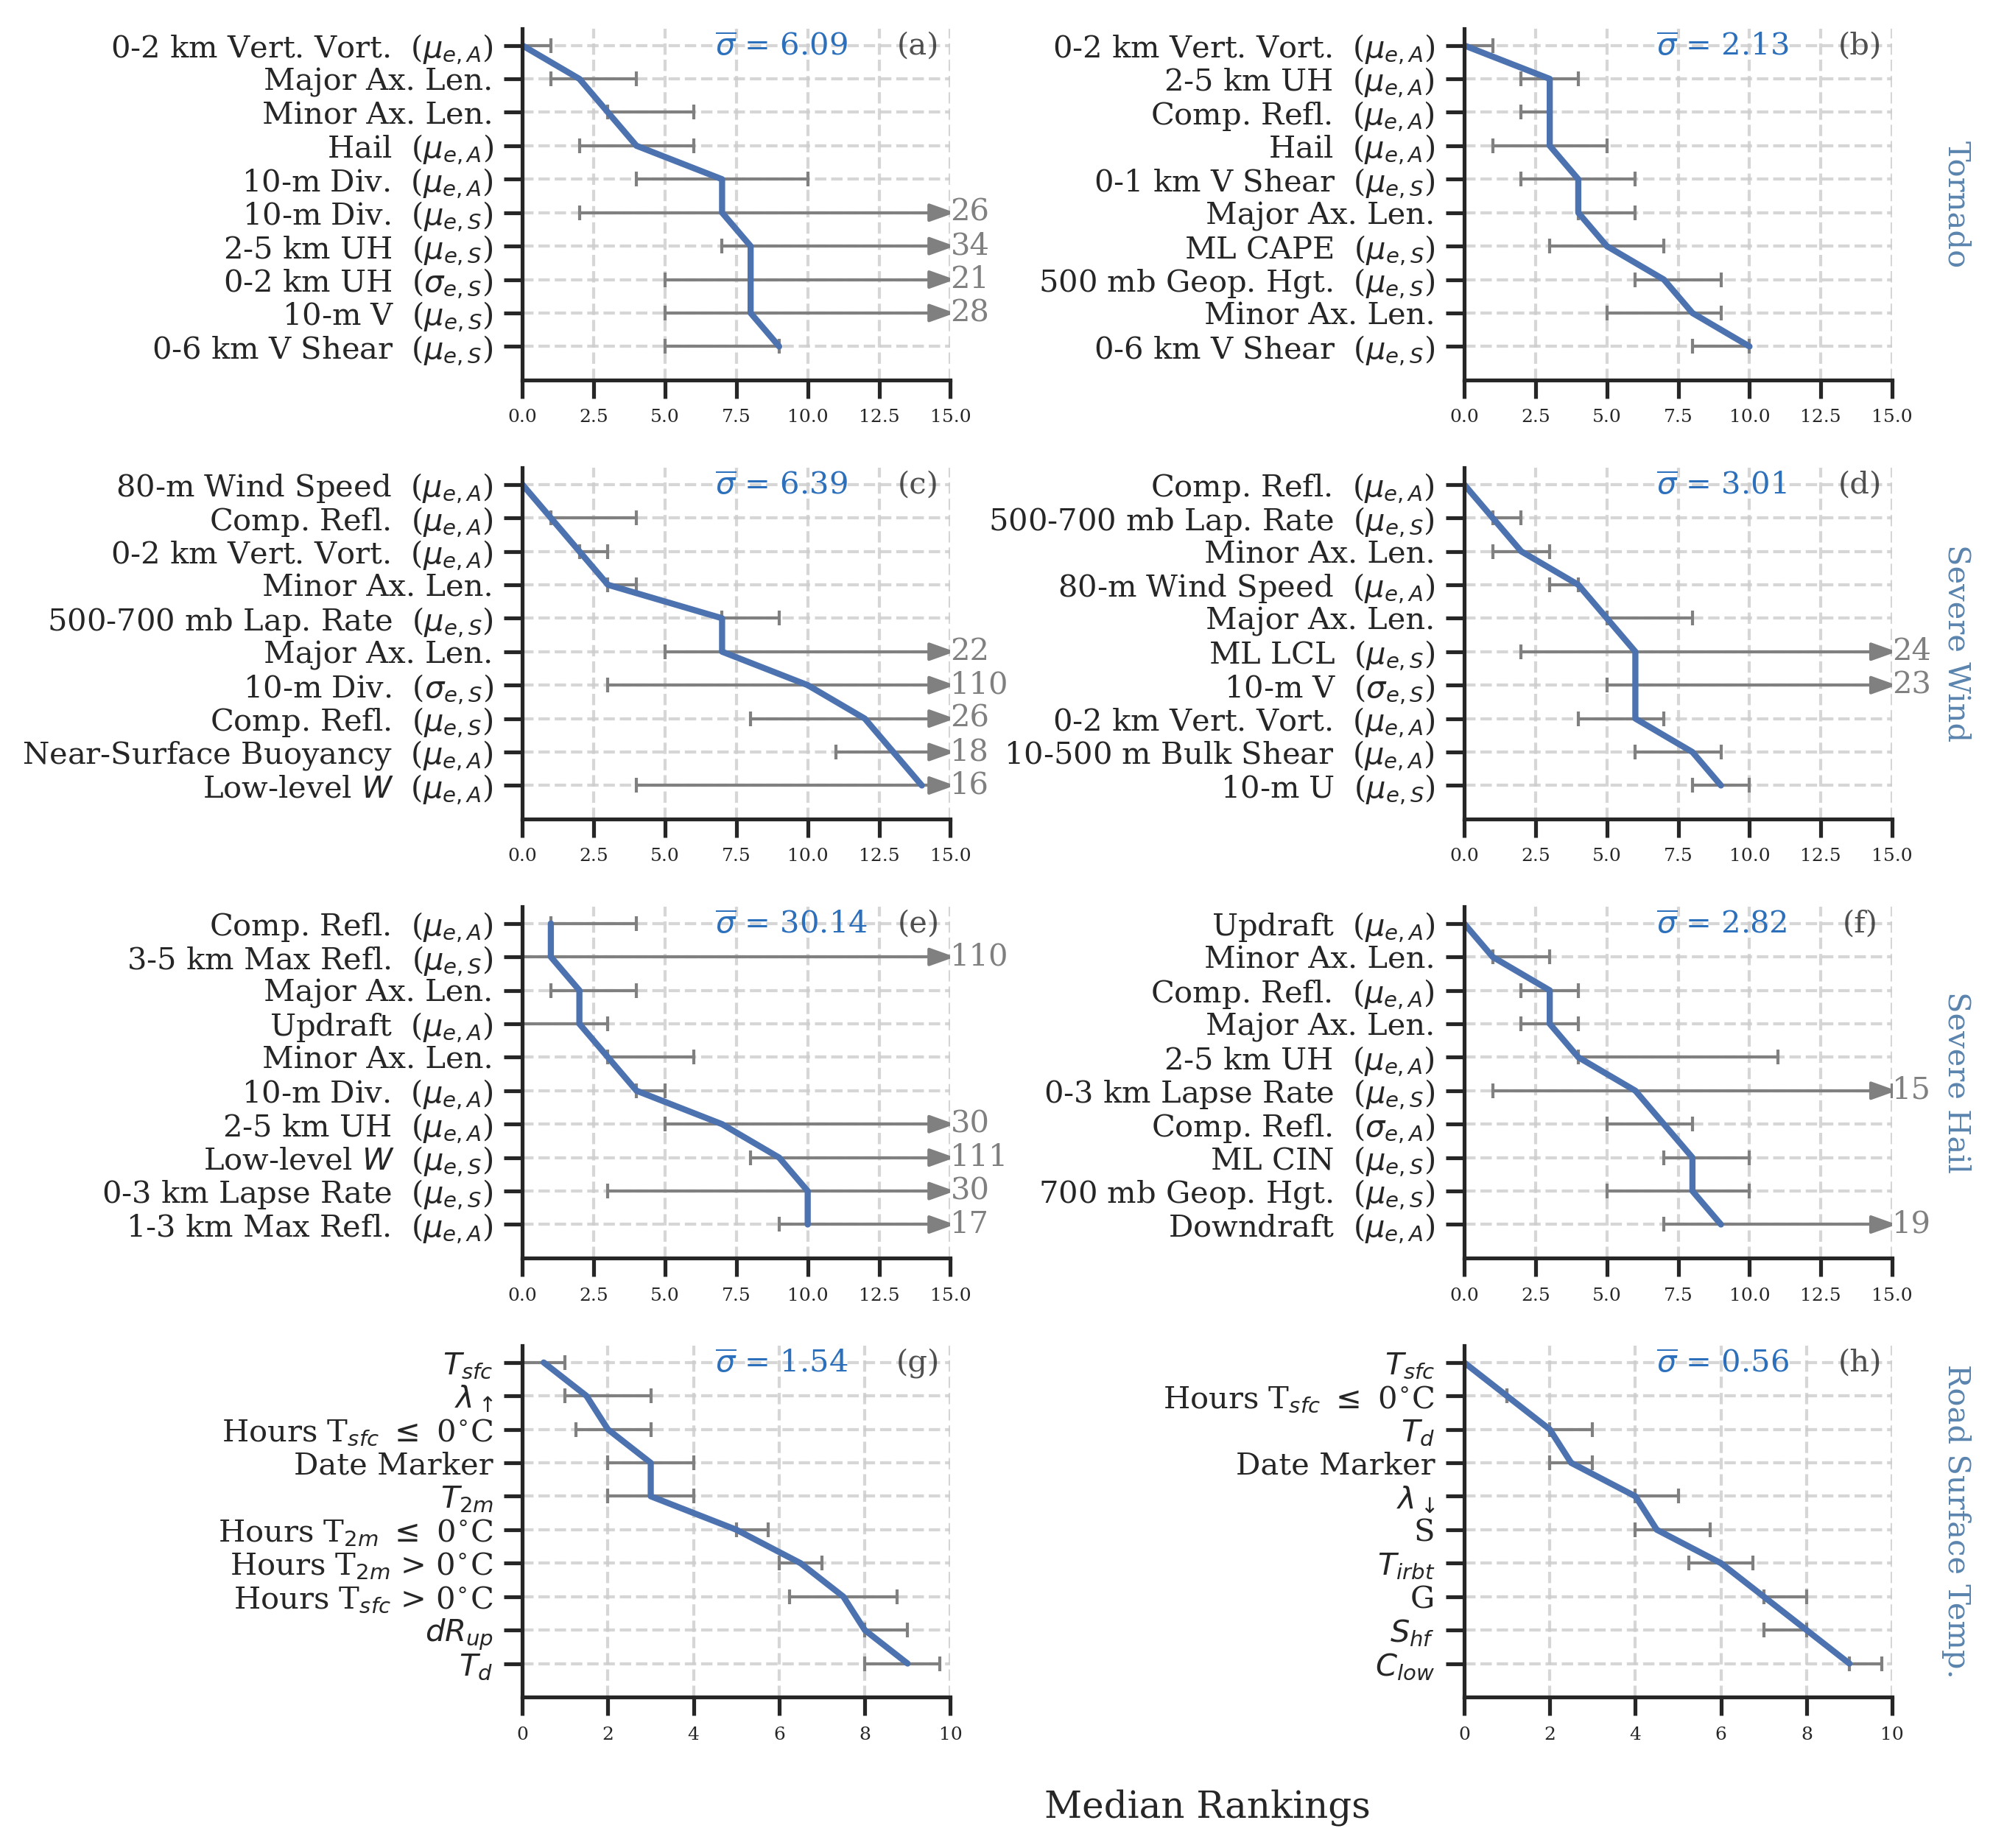

In [11]:
hazards = ['tornado', 'severe_wind', 'severe_hail', 'road_surface']
options = ['original', 'reduced']

# Only include the top features in the method-averaging. 
n_top_features = 10

# Bootstrap iterations of random rankings. 
N=30

compute_uncertainty=False

base_plt = PlotStructure(BASE_FONT_SIZE = 12)
f, axes = base_plt.create_subplots(n_panels=8, n_columns=2, figsize=(8,10), dpi=300, 
                                      wspace=1.2, hspace=0.25)

for i, hazard in enumerate(hazards):
    vals_temp = []
    for j, opt in enumerate(options):
        # Load the feature rankings. 
        rankings, methods, name, features = load_imp(hazard, opt)
        
        # Compute the median ranking from the feature rankings. 
        avg_result = method_average_ranking(rankings, 
                                            features, 
                                            methods, 
                                            estimator_name=name, 
                                            )
        
        # Using the median ranking, get the top features. 
        top_features = avg_result[f'combined_rankings__{name}'].values[:n_top_features]
        
        # For those top features, get the rank matrix.
        df = get_rank_matrix(rankings, methods, features, name)
        
        if compute_uncertainty:
            val, vals = rank_uncertainty(df, N, top_features)
        else:
            df = mask_dataframe(df, top_features)
            val = average_norm_rank_var(df)
            
        #exp_val, exp_vals = expected_rank_uncertainty(methods, features, name, 
        #                                    top_features, N=N)
        
        if compute_uncertainty:
            vals_temp.append(vals/exp_vals)
            
        weight = 'normal'
        if j==1 and compute_uncertainty:
            # Compute 
            p_val = stat_testing(vals_temp[1], vals_temp[0])
            weight = 'bold' if p_val < 0.05 else 'normal'
        
        xlims = [0,10] if hazard == 'road_surface' else [0,15]
        
        plot_mean_rankings(axes[i,j], avg_result, estimator = name, display_feature_names=display_feature_names, 
                          xlims=xlims)
        
    
        #txt = f'Ratio : {val/exp_val:.02f}'
        #axes[i,j].annotate(txt, (0.05, 0.25), xycoords='axes fraction', fontsize=10, color = 'xkcd:medium blue', 
        #                  weight=weight)

        
        txt = fr'$\overline{{\sigma}}$ = {val:.02f}'
        axes[i,j].annotate(txt, (0.45, 0.925), xycoords='axes fraction', fontsize=10, color = 'xkcd:medium blue')

        #txt = fr'$\mathbb{{E}}$($\overline{{\sigma}})$ = {exp_val:.02f}'
        #axes[i,j].annotate(txt, (0.05, 0.05), xycoords='axes fraction', fontsize=10, color = 'xkcd:medium blue')
        
        
major_ax = base_plt.set_major_axis_labels(f, xlabel='Median Rankings', 
                              )
major_ax.grid(False)
base_plt.add_alphabet_label(n_panels=8, axes=axes, pos=(0.925, 0.95), fontsize=16)
labels = ['Tornado', 'Severe Wind', 'Severe Hail', 'Road Surface Temp.']
base_plt.set_row_labels(labels, 
                        axes, 
                        pos=-1, 
                        pad=1.15, 
                        rotation=270,
                       )

## Measure the reduction in rank uncertainty when only using the top 3 feature rankings. 

In [57]:
hazards = ['tornado', 'severe_wind', 'severe_hail', 'road_surface']
options = ['original', 'reduced']

n_top_features = 10

top_inds = {'Original': {
                    'Tornado' : ['coefs', 'shap_sum', 'lime'  ],
                    'Severe Hail' : ['coefs', 'shap_sum', 'lime'],
                    'Severe Wind' : ['shap_sum', 'lime', 'ale_variance' ],
                    'Road Surface' : ['lime', 'shap_sum', 'ale_variance', ],
                        
                        },
            'Reduced': {
                'Tornado' : ['coefs', 'shap_sum', 'backward_singlepass' ],
                'Severe Hail' : ['backward_singlepass', 'forward_multipass', 'shap_sum'  ],
                'Severe Wind' : ['lime', 'forward_multipass', 'backward_singlepass'],
                'Road Surface' : [ 'shap_sum', 'backward_singlepass', 'lime',],
                        
                        },
           }


print('Average Normalized Feature Ranking Variance (Top 15 Features)')
print(f'***Using a dataset-dependent top 3 methods***')
print('='*75)

dots_different = {'Original' : [], 
        'Reduced' : []}

for i, hazard in enumerate(hazards):
    for j, opt in enumerate(options):
        # Load the feature rankings. 
        rankings, methods, name, features = load_imp(hazard, opt)
        
        # Compute the median ranking from the feature rankings. 
        avg_result = method_average_ranking(rankings, 
                                            features, 
                                            methods, 
                                            estimator_name=name, 
                                            )
        
        # Using the median ranking, get the top features. 
        top_features = avg_result[f'combined_rankings__{name}'].values[:n_top_features]
        
        # For those top features, get the rank matrix.
        df = get_rank_matrix(rankings, methods, features, name)
        
        df = mask_dataframe(df, top_features)
        
        val = average_norm_rank_var(df)

        _inds = top_inds[opt.capitalize()][hazard.replace('_', ' ').title()]
        _inds = [list(df.index).index(i) for i in _inds]
        
        print(df.iloc[_inds,:].index)
        
        top_val = average_norm_rank_var(df.iloc[_inds,:])
        arr = [average_norm_rank_var(df.iloc[list(inds),:])
             for inds in itertools.combinations(range(df.shape[0]-1), r=3) if inds != tuple(_inds)]
        
        rand_val, rand_std = np.nanmean(arr), np.nanstd(arr, ddof=1)

        title = f'{opt.capitalize()} {hazard}'
        
        print('\n', title)
        print('*'*(len(title)+3))
        print(f'All Methods                : {val:.03f}')
        print(f'Top 3 Methods              : {top_val:.03f}')
        print(f'Avg. from 3 Random Methods : {rand_val:.03f} +/- {rand_std:.05f}')
        print(f'Ratio b/t Top and Random   : {top_val/rand_val:.03f}')
    
        dots_different[opt.capitalize()].append(top_val/rand_val)
    
print('='*50)

Average Normalized Feature Ranking Variance (Top 15 Features)
***Using a dataset-dependent top 3 methods***
Index(['coefs', 'shap_sum', 'lime'], dtype='object')

 Original tornado
*******************
All Methods                : 6.095
Top 3 Methods              : 1.728
Avg. from 3 Random Methods : 7.133 +/- 5.17115
Ratio b/t Top and Random   : 0.242
Index(['coefs', 'shap_sum', 'backward_singlepass'], dtype='object')

 Reduced tornado
******************
All Methods                : 2.125
Top 3 Methods              : 0.990
Avg. from 3 Random Methods : 1.435 +/- 0.44747
Ratio b/t Top and Random   : 0.690
Index(['shap_sum', 'lime', 'ale_variance'], dtype='object')

 Original severe_wind
***********************
All Methods                : 6.392
Top 3 Methods              : 3.326
Avg. from 3 Random Methods : 4.292 +/- 1.78614
Ratio b/t Top and Random   : 0.775
Index(['lime', 'forward_multipass', 'backward_singlepass'], dtype='object')

 Reduced severe_wind
**********************
All Methods

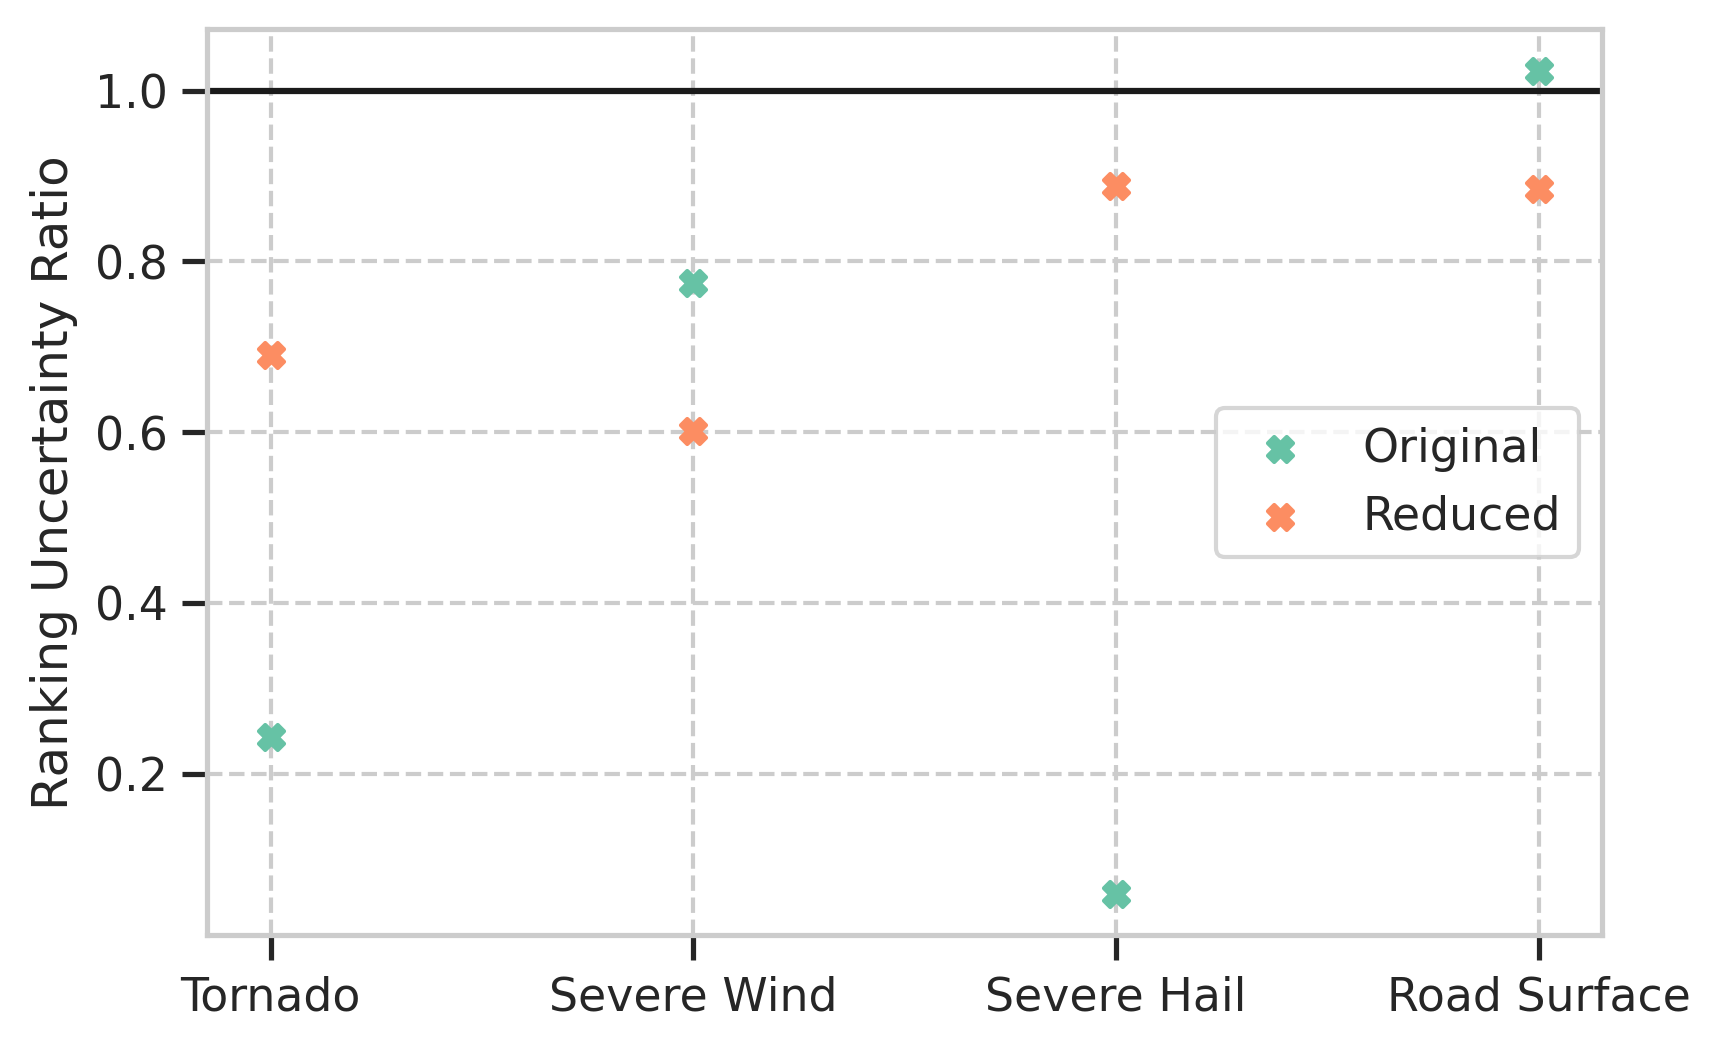

In [59]:
sns.set_theme(style='whitegrid',
              palette=sns.color_palette("Set2"), rc={"xtick.bottom" : True, "ytick.left" : True})


f, ax = plt.subplots(dpi=300)
y1 = dots_different['Original']
ax.scatter(range(len(y1)), y1, marker='X', label='Original')
ax.set_ylabel('Ranking Uncertainty Ratio')

y2 = dots_different['Reduced']
ax.scatter(range(len(y2)), y2, marker='X', label='Reduced')
#add_arrows(ax, y1, y2)

ax.set_xticks(ticks=range(len(y1)), labels=names)
ax.grid(ls='dashed')

ax.axhline(1.0, color='k')

ax.legend(loc='center right')